# <font color=black>**1. Install Dependencies and Setup**</font>

In [1]:
!pip install flickrapi
!pip install opencv-python

In [39]:
import tensorflow as tf
import requests
from  flickrapi import FlickrAPI
from PIL import Image
from io import BytesIO
import urllib.request
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import imghdr

# <font color=black>**2. Download the data**</font>

In [3]:
key = "d8b6992d8edbf4905f3f9b7053a893d9"
secret = "23bf7fa245fde760"

In [4]:
flickr = FlickrAPI(key, secret, format='etree')

In [5]:
#Getting URLS of the dog images from flickr API

keyword1 = "dog"
photos_dog = flickr.walk(text=keyword1,
                     tag_mode='all',
                     tags=keyword1,
                     extras='url_c',
                     per_page=400,
                     sort='relevance')
urls_dog = []
counter=0
for i, photo in enumerate(photos_dog):
    url=photo.get('url_c')
    if counter==300:
        break
    if url is None:
        continue
    else:
        urls_dog.append(url)
        counter+=1

In [6]:
#Getting URLS of the cat images from flickr API

keyword2 = "cat"
photos_cat = flickr.walk(text=keyword2,
                     tag_mode='all',
                     tags=keyword2,
                     extras='url_c',
                     per_page=400,
                     sort='relevance')
urls_cat = []
counter=0
for i, photo in enumerate(photos_cat):
    url=photo.get('url_c')
    if counter==300:
        break
    if url is None:
        continue
    else:
        urls_cat.append(url)
        counter+=1

In [7]:
#Getting URLS of the elephant images from flickr API

keyword3 = "elephant"
photos_elephant = flickr.walk(text=keyword3,
                     tag_mode='all',
                     tags=keyword3,
                     extras='url_c',
                     per_page=400,
                     sort='relevance')
urls_elephant = []
counter=0
for i, photo in enumerate(photos_elephant):
    url=photo.get('url_c')
    if counter==300:
        break
    if url is None:
        continue
    else:
        urls_elephant.append(url)
        counter+=1

In [8]:
#Downloading and saving images in corresponding directories dog, cat and elephant

save_path = '/Users/eminmammadov/Desktop/CNN_animals/data/'
for i in range(300):
    urllib.request.urlretrieve(urls_dog[i], save_path+f'/{keyword1}/'+f'{keyword1}_{i}.jpg')
for i in range(300):
    urllib.request.urlretrieve(urls_cat[i], save_path+f'/{keyword2}/'+f'{keyword2}_{i}.jpg')
for i in range(300):
    urllib.request.urlretrieve(urls_elephant[i], save_path+f'/{keyword3}/'+f'{keyword3}_{i}.jpg')

# <font color=black>**3. Remove dodgy images**</font>

In [9]:
data_dir='data'
image_exts=['jpeg','jpg','bmp','png']

In [13]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# <font color=black>**4. Load the data**</font>

In [2]:
'''The function 'image_dataset_from_directory' takes in the path to the directory containing the image files, 
and uses the subdirectories within that directory as class labels.'''

data = tf.keras.utils.image_dataset_from_directory('data')

Found 824 files belonging to 3 classes.


2023-03-09 21:12:22.026620: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#We make out data iterable and convert the elements of the dataset to numpy arrays

data_iterator = data.as_numpy_iterator()

In [4]:
#Let's take a sample batch from the data to analyze

batch = data_iterator.next()

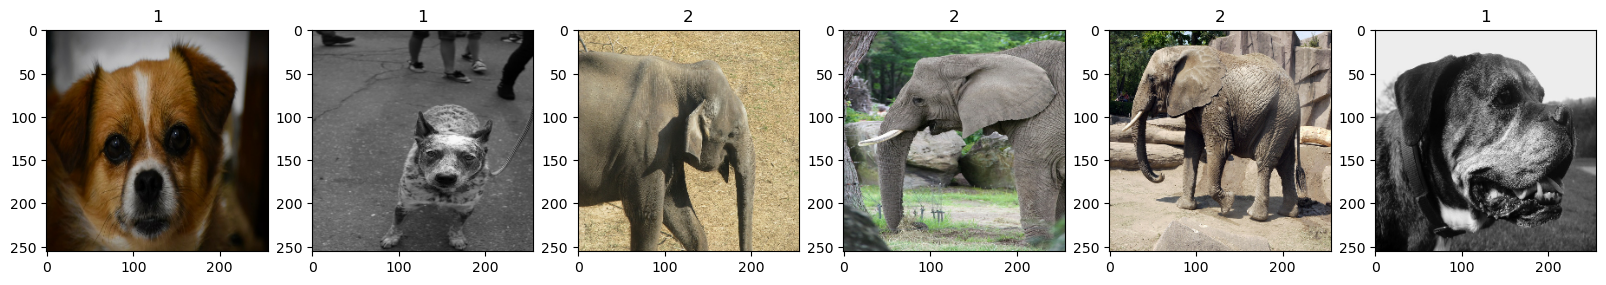

In [7]:
#As we can see from the plots the labels are following: Class 0=cat, Class 1=dog and Class 2=elephant

fig, ax = plt.subplots(ncols=6, figsize=(20,20))
for idx, img in enumerate(batch[0][:6]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# <font color=black>**5. Preprocess the data**</font>

In [8]:
#Scale the data

data = data.map(lambda x, y: (x/255, y))

In [9]:
data.as_numpy_iterator().next()[1]

array([2, 2, 1, 1, 0, 2, 0, 0, 2, 2, 0, 1, 1, 0, 2, 2, 2, 1, 2, 2, 0, 1,
       2, 1, 1, 1, 2, 2, 0, 0, 0, 2], dtype=int32)

In [10]:
#We have 26 batches

len(data)

26

In [11]:
#Split the data into train (18), test (5) and validation sets (3) to avoid overfitting

train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [12]:
(train_size+val_size+test_size)==len(data)

True

In [13]:
train = data.take(train_size)     #18 batches of training data
val = data.skip(train_size).take(val_size)     #5 batches of validation data
test = data.skip(train_size+val_size).take(test_size)     #3 batches of test data

In [14]:
train.as_numpy_iterator().next()[1]

array([0, 0, 2, 0, 1, 1, 0, 2, 2, 2, 2, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 2,
       0, 1, 0, 0, 2, 1, 0, 0, 1, 0], dtype=int32)

# <font color=black>**6. Build the Deep Learning Model**</font>

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten,Dense,Dropout

In [16]:
model=Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [17]:
model.compile('adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# <font color=black>**7. Train the Model**</font>

In [47]:
hist=model.fit(train,epochs=20,validation_data=val,callbacks=[BotCallback(personal_token='5631530887:AAENs0mbgOr6-wImJOtSgXNpI6h4sMVqaxY')])

Epoch 1/20
18/18 [==============================] - 9s 448ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.0083 - val_accuracy: 1.0000
Epoch 2/20
18/18 [==============================] - 8s 434ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0266 - val_accuracy: 0.9937
Epoch 3/20
18/18 [==============================] - 9s 466ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0207 - val_accuracy: 0.9937
Epoch 4/20
18/18 [==============================] - 9s 459ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 5/20
18/18 [==============================] - 9s 484ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 6/20
18/18 [==============================] - 9s 490ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0103 - val_accuracy: 0.9937
Epoch 7/20
18/18 [==============================] - 9s 494ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 

# <font color=black>**8. Plotting the training performance**</font>

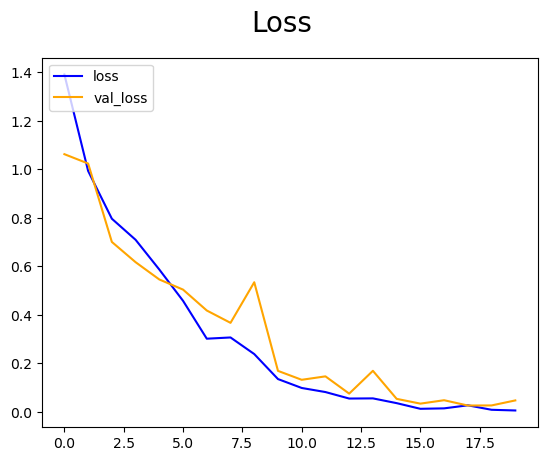

In [28]:
#Visualizing the loss

fig = plt.figure()
plt.plot(hist.history['loss'], color='blue', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

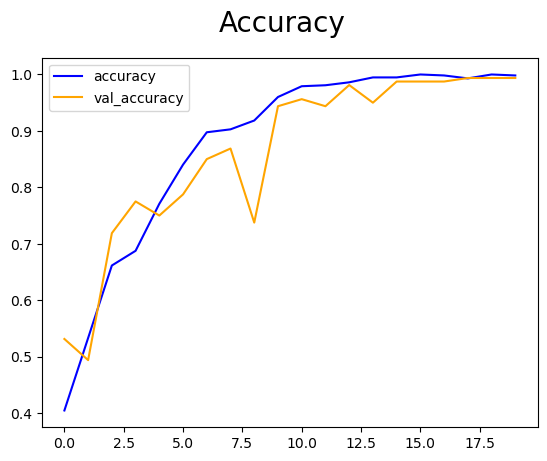

In [29]:
#Visualizing the accuracy

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='blue', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# <font color=black>**9. Model evaluation**</font>

In [30]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [48]:
prec = Precision()
rec = Recall()
acc=CategoricalAccuracy()

In [49]:
#As our model outputs 3 probabilities for each element in batch which makes the shape of yhat (32,3). We convert it to (32,) by choosing the index with highest probability
#Our prediction comes out as probabilities which are floats

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat_probs = model.predict(X)  # shape: (32, 3)
    yhat = yhat_probs.argmax(axis=1)  # shape: (32,)
    prec.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 106ms/step


In [50]:
print(f'Precision:{prec.result().numpy()}, Recall:{rec.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


# <font color=black>**10. Testing**</font>

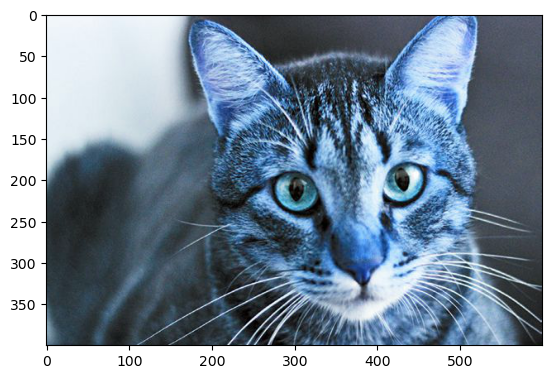

In [44]:
#Testing our model on random images from web

img = cv2.imread('cat.jpg')
plt.imshow(img)
plt.show()

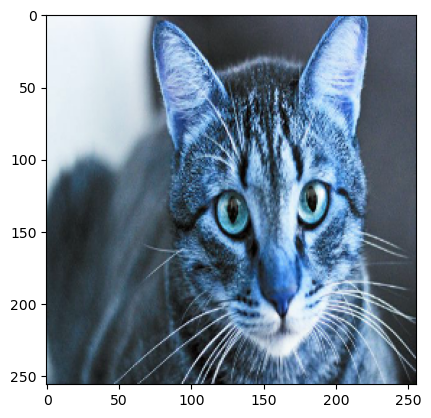

In [45]:
#Let's resize the image

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [46]:
#Our model can accept only batches as an input so we add one more dimension to our input so that it acts as batch of 1
#Then we choose the class with highest probability and in this case it is the class 2 which is Elephant, our model has succesfully classified it

yhat_probs = model.predict(np.expand_dims(resize/255, 0))
yhat = yhat_probs.argmax(axis=1)
print(yhat)

1/1 [==============================] - 0s 38ms/step
[0]


# <font color=black>**11. Saving the model**</font>

In [318]:
from tensorflow.keras.models import load_model

In [319]:
model.save(os.path.join('models','animalclassifier.h5'))

In [321]:
new_model = load_model('models/animalclassifier.h5')

In [323]:
prediction=new_model.predict(np.expand_dims(resize/255, 0)).argmax(axis=1)
print(prediction)

1/1 [==============================] - 0s 41ms/step
[2]


# <font color=black>**Telegram Bot**</font>

In [21]:
!pip install python-telegram-bot

In [24]:
personal_token='5631530887:AAENs0mbgOr6-wImJOtSgXNpI6h4sMVqaxY'
ping_url = 'https://api.telegram.org/bot'+str(personal_token)+'/getUpdates'
response = requests.get(ping_url).json()
response

{'ok': True,
 'result': [{'update_id': 257323903,
   'message': {'message_id': 136,
    'from': {'id': 1271149257,
     'is_bot': False,
     'first_name': 'Emin',
     'username': 'Hlfg27',
     'language_code': 'en'},
    'chat': {'id': 1271149257,
     'first_name': 'Emin',
     'username': 'Hlfg27',
     'type': 'private'},
    'date': 1678387538,
    'text': 'kyuky'}},
  {'update_id': 257323904,
   'message': {'message_id': 197,
    'from': {'id': 1271149257,
     'is_bot': False,
     'first_name': 'Emin',
     'username': 'Hlfg27',
     'language_code': 'en'},
    'chat': {'id': 1271149257,
     'first_name': 'Emin',
     'username': 'Hlfg27',
     'type': 'private'},
    'date': 1678392806,
    'text': 'tgnfg'}}]}

In [25]:
chat_id = response['result'][0]['message']['chat']['id']

In [26]:
class BotCallback(tf.keras.callbacks.Callback):
    def __init__(self,personal_token):
        self.personal_token = personal_token
        self.ping_url = 'https://api.telegram.org/bot'+str(self.personal_token)+'/getUpdates'
        self.response = requests.get(self.ping_url).json()
        self.chat_id = self.response['result'][0]['message']['chat']['id']

    def send_message(self,message):
        self.ping_url = 'https://api.telegram.org/bot'+str(self.personal_token)+'/sendMessage?'+\
                        'chat_id='+str(self.chat_id)+\
                        '&parse_mode=Markdown'+\
                        '&text='+message
        self.response = requests.get(self.ping_url)

    def on_epoch_end(self, epoch,logs=None):
        message = f"Epoch: {epoch+1}\nTrain Loss - {logs.get('loss')}\nValidation Loss - {logs.get('val_loss')}\n \
        Train Acc - {logs.get('accuracy')}\nValidation Acc - {logs.get('val_accuracy')}"
        self.send_message(message)